In [1]:
import os
import csv
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.models import model_from_json
from keras.optimizers import Adam
from keras.layers.advanced_activations import ELU
from keras.layers import Flatten, Dense, Lambda, Dropout
from keras.layers.convolutional import Convolution2D

Using TensorFlow backend.


In [2]:
def read_csv(directory):
    with open(directory + '/driving_log.csv', 'r') as csvfile:
        lines = []
        reader = csv.reader(csvfile)
        
        for i, line in enumerate(reader):
            if i != 0:
                lines.append(line)
    
        return lines
    
def load_image(source_path):
    file_dir = source_path.split('/')[-4:-1]
    filename = source_path.split('/')[-1]
    path = os.path.join(*file_dir) + '/' + filename
    image = cv2.imread(path)
    image = image[60:140, :, :] # y1:y2, x1:x2
    image = cv2.GaussianBlur(image, (3,3), 0)
    image = cv2.resize(image,(200, 66), interpolation = cv2.INTER_AREA)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    
    return image.astype(np.uint8)

def build_generator(files, steerings, batch_size):
    while True:
        X = np.zeros((0, 66, 200, 3), dtype=np.uint8)
        y = np.zeros((0, 1), dtype=np.float16)

        for i in range(batch_size):
            idx = np.random.choice(len(files), 1)[0]
            feature = load_image(files[idx])
            X = np.append(X, feature[None,:], axis=0)
            flipped_feature = cv2.flip(feature, 1)
            X = np.append(X, flipped_feature[None,:], axis=0)
            
            label = steerings[idx]
            y = np.append(y, label)
            y = np.append(y, -1 * label)
        
        yield shuffle(X, y)
        
def remove_low_steering(files, steerings):
    filtered_files = []
    filtered_steerings = []
    
    for idx, steering in enumerate(steerings):
        if abs(steering) >= 0.15:
            filtered_files.append(files[idx])
            filtered_steerings.append(steering)
        else:
            random = np.random.randint(10)
            
            if random < 10:
                filtered_files.append(files[idx])
                filtered_steerings.append(steering)

    print("Dropped {} rows with low steering".format(len(files) - len(filtered_files)))
    return filtered_files, filtered_steerings
        
def filter_bias_data(files, steerings):
    files, steerings = remove_low_steering(files, steerings)
    
    num_bins = 100
    avg_samples_per_bin = int(math.ceil(len(steerings) / num_bins))
    hist, bins = np.histogram(steerings, num_bins)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.plot((np.min(steerings), np.max(steerings)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')

    keep_probs = []
    target = avg_samples_per_bin * 0.2
    remove_list = []
    
    for i in range(num_bins):
        if hist[i] < target:
            keep_probs.append(1.0)
        else:
            keep_probs.append(1.0 / (hist[i] / target))

    for i in range(len(steerings)):
        for j in range(num_bins):
            if steerings[i] > bins[j] and steerings[i] <= bins[j+1]:
                if np.random.rand() > keep_probs[j]:
                    remove_list.append(i)
                    
    files_filtered = np.delete(files, remove_list, axis=0)
    steerings_filtered = np.delete(steerings, remove_list)

    hist, bins = np.histogram(steerings_filtered, num_bins)
    plt.bar(center, hist, align='center', width=width)
    plt.plot((np.min(steerings_filtered), np.max(steerings_filtered)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.hist(steerings, bins=num_bins)
    ax2.hist(steerings_filtered, bins=num_bins)
    plt.show()
    plt.close(f)
    
    return files_filtered, steerings_filtered
    
def load_data(directory):
    csv_lines = read_csv(directory)
#     f, ax_list = plt.subplots(1, 3, figsize=(10, 4))
    
#     for i in range(3):
#         img = load_image(csv_lines[0][i])
#         ax_list[i].imshow(img, cmap='gray')
#         ax_list[i].axis("off")

#     plt.show()
    
    return csv_lines

def split_on_batches(train_samples, valid_samples, size=32):
    train_lines_num = len(train_samples)
    train_batches = train_lines_num // size
    train_samples_num = size * train_batches
    train_csv_lines = train_samples[:train_samples_num]
    train = train_csv_lines, train_batches
    
    valid_lines_num = len(valid_samples)
    valid_batches = valid_lines_num // size
    valid_samples_num = size * valid_batches
    valid_csv_lines = valid_samples[:valid_samples_num]
    valid = valid_csv_lines, valid_batches
    
    return train, valid, size

In [3]:
def train_model(model_path, train, valid, batch_size, epochs):
    train_data, train_batches = train
    train_files, train_steerings = zip(*train_data)
    
    valid_data, valid_batches = valid
    valid_files, valid_steerings = zip(*valid_data)

    train_samples_num = len(train_files)
    train_generator = build_generator(train_files, train_steerings, batch_size)
    valid_samples_num = len(valid_files)
    valid_generator = build_generator(valid_files, valid_steerings, batch_size)

    model = None
    show_summary = False
    
    if Path(model_path + ".json").is_file():
        with open(model_path + ".json", "r") as json_file:
            loaded_model_json = json_file.read()
            json_file.close()
            model = model_from_json(loaded_model_json)
            model.load_weights(model_path + ".h5")
            print("Loaded model from disk")
    else:
        show_summary = True
        
    if model is None:
        print("Create new model")
        model = Sequential()
        model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(66,200,3)))

        model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode='valid'))
        model.add(ELU())
        model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode='valid'))
        model.add(ELU())
        model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode='valid'))
        model.add(ELU())
        model.add(Convolution2D(64, 3, 3, border_mode='valid'))
        model.add(ELU())
        model.add(Convolution2D(64, 3, 3, border_mode='valid'))
        model.add(ELU())
        model.add(Dropout(0.4))
        
        model.add(Flatten())
        model.add(Dropout(0.5))
        model.add(ELU())
        
        model.add(Dense(100))
        model.add(ELU())

        model.add(Dense(50))
        model.add(ELU())

        model.add(Dense(10))
        model.add(ELU())

        model.add(Dense(1))
    
    optimizer = Adam(lr=1e-4)
    model.compile(loss='mse', optimizer=optimizer)

    history = model.fit_generator(train_generator, samples_per_epoch=2*train_samples_num, validation_data=valid_generator, nb_val_samples=2*valid_samples_num, nb_epoch=epochs, verbose=1)
    print(history.history)
    
    model.save_weights(model_path + ".h5")
    model_json = model.to_json()
    with open(model_path + ".json", "w") as json_file:
        json_file.write(model_json)

    if show_summary:
        model.summary()

Dropped 0 rows with low steering


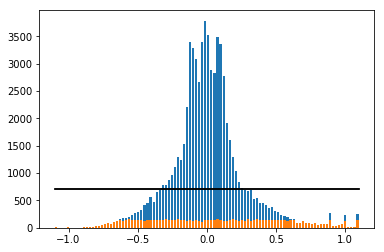

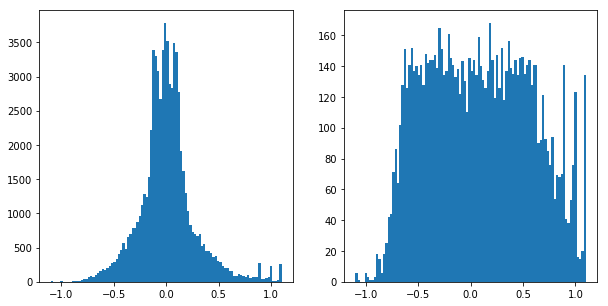

Loaded model from disk
Epoch 1/10
14400/14400 [==============================] - 216s - loss: 0.0115 - val_loss: 0.0103
Epoch 2/10
14400/14400 [==============================] - 212s - loss: 0.0108 - val_loss: 0.0098
Epoch 3/10
14400/14400 [==============================] - 211s - loss: 0.0107 - val_loss: 0.0098
Epoch 4/10
14400/14400 [==============================] - 212s - loss: 0.0105 - val_loss: 0.0107
Epoch 5/10
14400/14400 [==============================] - 226s - loss: 0.0102 - val_loss: 0.0103
Epoch 6/10
14400/14400 [==============================] - 213s - loss: 0.0102 - val_loss: 0.0101
Epoch 7/10
14400/14400 [==============================] - 211s - loss: 0.0103 - val_loss: 0.0109
Epoch 8/10
14400/14400 [==============================] - 216s - loss: 0.0097 - val_loss: 0.0102
Epoch 9/10
14400/14400 [==============================] - 220s - loss: 0.0099 - val_loss: 0.0099
Epoch 10/10
14400/14400 [==============================] - 220s - loss: 0.0092 - val_loss: 0.0106
{'loss

In [6]:
for i in range(1):
    files = []
    steerings = []
    # directories = ["Track1.1", "Track1.2", "Track1.3", "Track1.4", "Track1.5", "Track1.6", 
    #                "Track1.7 - left border","Track1.8 - borders", "Track1.9 - full", "Track1.9.1 - full", 
    #                "Track1.9.2 - full", "Track1.9.3 - full", "Track1.9.4 - full", "Track2", 
    #                "Track2.1 - full", "Track2.2 - full"]

#     directories = ["Track1.9.2 - full", "Track2.1 - full"]
#     directories = ["Track1.9.1 - full", "Track2"]
    directories = ["Track1.3", "Track1.4", "Track1.5", "Track2.1 - full", "Track2.2 - full"]
    steering_offsets = [0.0, 0.1, -0.1] # center, left, right

    for directory in directories:
        lines = load_data("data/" + directory)

        for line in lines:
            for idx, offset in enumerate(steering_offsets):
                offset = float(line[3]) + steering_offsets[idx]
                steerings.append(offset)
                files.append(line[idx])

    filtered_files, filtered_steerings = filter_bias_data(files, steerings)

    train_samples, valid_samples = train_test_split(list(zip(filtered_files, filtered_steerings)), test_size=0.3)
    train, valid, size = split_on_batches(train_samples, valid_samples)
    train_model("model/p3_model", train, valid, size, epochs=10)
    
print("We're done")